# prepare dataset
this project use dataset :
 https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json

this dataset includes 11k posts related to 20 different topics that have been labeled.

In [2]:
# Import Dataset
import pandas as pd
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


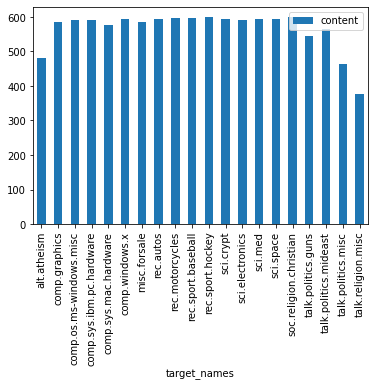

In [3]:
# visualize number of topics
df[['target_names', 'content']].groupby(['target_names']).count().plot(kind='bar')

there are 20 groups, each group has the number of posts between 400-600. 

divided on topics such as auto, mobile, medicine,….


# Data preprocessing

In [4]:
import gensim
data = list(df['content'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'lerxst', 'wam', 'umd', 'edu', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]

## Build the bigram and trigram models

Currently the vocabulary is composed entirely of single words. To increase the accuracy of the model, we will need to cluster single words that appear together into collocations with a length of 2 or 3 words. We call them bigrams or trigrams.

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'lerxst', 'wam_umd', 'edu', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd', 'edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


Next we will remove the stopwords and only filter out the words that are words with the tag of the type ['NOUN', 'ADJ', 'VERB', 'ADV']. 

The stopwords is already integrated in the nltk package for English.

In [6]:
import nltk
nltk.download('stopwords')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
from gensim.utils import simple_preprocess
import spacy

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


# Create dictionary and corpus

The dictionary and the corpus are the two main inputs for the LDA model.

In [9]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]]


After processing, we have obtained a corpus which is a list of pairs (index, frequency) encoding documents about the index specified in the dictionary with their occurrence frequency in the text.

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]


# Build LDA model

The main parameter specified in the LDA model is the number of topics (num_topics),

 chunksize: The amount of text to be included in each training batch.
 
  passes is the number of training epochs.



In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)


After training the model, we  save it to a folder for future use.

In [14]:
lda_model.save("/content/drive/MyDrive/LDA_model_classification/model_lda_100.model")


And reload the model from the folder

In [16]:
# Load model
from gensim.models.ldamodel import LdaModel
lda = LdaModel.load("/content/drive/MyDrive/LDA_model_classification/model_lda_100.model")


# Topics obtained after training


After training the LDA model, we can find the distribution of documents by topics and represent topics according to the distribution of words.

can find the 10 most important words in each topic with their distribution weights.

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"people" + 0.017*"make" + 0.012*"want" + 0.010*"group" + '
  '0.010*"right" + 0.009*"order" + 0.009*"name" + 0.009*"new" + 0.009*"issue" '
  '+ 0.009*"ask"'),
 (1,
  '0.032*"sale" + 0.019*"israeli" + 0.016*"lebanese" + 0.015*"sell" + '
  '0.014*"price" + 0.013*"factory" + 0.011*"offer" + 0.011*"arab" + '
  '0.009*"processor" + 0.009*"include"'),
 (2,
  '0.020*"state" + 0.016*"law" + 0.016*"patient" + 0.015*"government" + '
  '0.013*"case" + 0.010*"report" + 0.009*"public" + 0.009*"crime" + '
  '0.009*"citizen" + 0.009*"right"'),
 (3,
  '0.023*"distribution" + 0.012*"library" + 0.010*"title" + 0.009*"quick" + '
  '0.009*"imaging" + 0.008*"cj" + 0.008*"trace" + 0.008*"ad" + '
  '0.008*"conference" + 0.008*"astronomy"'),
 (4,
  '0.017*"line" + 0.015*"use" + 0.013*"thank" + 0.012*"system" + 0.012*"need" '
  '+ 0.010*"work" + 0.010*"mail" + 0.010*"program" + 0.010*"problem" + '
  '0.010*"window"'),
 (5,
  '0.054*"team" + 0.051*"game" + 0.036*"play" + 0.018*"hockey" + '
  '0.01

example For topic 1 we see their representation as:



**'0.032*"sale" + 0.019*"israeli" + 0.016*"lebanese" + 0.015*"sell" + '
  '0.014*"price" + 0.013*"factory" + 0.011*"offer" + 0.011*"arab" + '
  '0.009*"processor" + 0.009*"include"''**

This means that the 10 most important words contributing to this topic include:

"sale" , "israeli"  ,"lebanese"  ,"sell" , "price"  ,"factory" , "offer" , "arab" , "processor" , "include"

Based on the feeling we can know that this topic is related to sales.

# Calculate the model's perplexity and coherence score

The perplexity and coherence scores measure the quality of the model as good or bad.

It is also used in finding out how many topics match the dataset.

Perplexity is built on the logarithm of the maximum rational function (MLE), so the lower the perplexity, the better the quality of the model.

In contrast, the higher the model's Coherence score, the better the model will be.

In [18]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.404981361079505

Coherence Score:  0.4858610022721634


In [22]:
!pip install pyLDAvis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.306503  0.024604       1        1  20.627568
4     -0.203356 -0.214219       2        1  13.467435
0     -0.249540  0.076332       3        1   9.067834
18    -0.260259  0.116301       4        1   8.355811
16    -0.096864 -0.123526       5        1   7.223555
13     0.141209  0.053404       6        1   5.239236
11    -0.086216 -0.037947       7        1   4.927812
19     0.002864 -0.214772       8        1   3.913549
15    -0.047989  0.240950       9        1   3.631932
2      0.000013  0.160050      10        1   3.337128
14     0.025884 -0.100025      11        1   3.294652
12     0.088564 -0.042745      12        1   2.444001
1      0.066337  0.036922      13        1   2.215852
5      0.101968  0.025699      14        1   2.212504
9      0.098756 -0.046245      15        1   2.090358
7      0.114052 -0.003444      16        1   2.071360
17     0.131355 -0.012493      17        1   1.851556
3      0.146998  0.002916      18        1   1.533185
8      0.152693  0.011527      19        1   1.435953
6      0.180033  0.046711      20        1   1.058719, topic_info=          Term          Freq         Total Category  logprob  loglift
4473        ax  50150.000000  50150.000000  Default  30.0000  30.0000
17        line  12201.000000  12201.000000  Default  29.0000  29.0000
182        com   8974.000000   8974.000000  Default  28.0000  28.0000
202      write   9662.000000   9662.000000  Default  27.0000  27.0000
43     article   6522.000000   6522.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
20405      scx     37.946182     39.093577  Topic20  -5.8914   4.5183
4699       umu     94.323523    112.790164  Topic20  -4.9808   4.3693
4516        ei    113.021349    179.440998  Topic20  -4.7999   4.0858
1087        sc    130.025868    234.704927  Topic20  -4.6598   3.9575
4492        ch     52.078488     61.981999  Topic20  -5.5748   4.3740

[970 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4467     20  0.997914         _
1372      3  0.267391    accept
1372      4  0.731949    accept
4147      6  0.992771  activate
3875     18  0.990396        ad
...     ...       ...       ...
38        9  0.001650      year
38       10  0.014852      year
38       12  0.070134      year
38       13  0.006326      year
38       14  0.092137      year

[1689 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 1, 19, 17, 14, 12, 20, 16, 3, 15, 13, 2, 6, 10, 8, 18, 4, 9, 7])

# Find out the main topics of the document

As we know topics in LDA are hidden topics, so is there any way we can similarly identify the main topic of these documents?

 The answer is yes, based on the distribution of topics according to words, we can find out which words are most important for each topic and it is likely that the topic will be related to this word the most, so assign a hidden meaning to the topic Relativity is the word.

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.2658,"get, go, think, time, say, know, well, see, go...",From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1,4.0,0.3911,"line, use, thank, system, need, work, mail, pr...",From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2,10.0,0.4889,"get, go, think, time, say, know, well, see, go...",From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3,4.0,0.2778,"line, use, thank, system, need, work, mail, pr...",From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4,16.0,0.2270,"write, com, line, article, organization, nntp_...",From: jcm@head-cfa.harvard.edu (Jonathan McDow...
5,5,16.0,0.5125,"write, com, line, article, organization, nntp_...",From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...
6,6,4.0,0.2819,"line, use, thank, system, need, work, mail, pr...",From: bmdelane@quads.uchicago.edu (brian manni...
7,7,8.0,0.3791,"drive, scsi, controller, jumper, diagnosis, pa...",From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...
8,8,10.0,0.2454,"get, go, think, time, say, know, well, see, go...",From: holmes7000@iscsvax.uni.edu\nSubject: WIn...
9,9,4.0,0.3532,"line, use, thank, system, need, work, mail, pr...",From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...
